# Conduct SHAP analysis to characterize drift

* Compare drift on External Test versus Traceability sets (mean abs)
* Compare time-evolution of reference set (Training and External Test) and analysis set (Traceability)

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta
# SHAP
import shap
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors
# SKLEARN
from sklearn.model_selection import KFold
PROCESSED = "Processed/"

### Construct time-ordered batches

In [2]:
# Load model and data
with open(f"{PROCESSED}trainCohort", "rb") as fp:
    train = pickle.load(fp)
with open(f"{PROCESSED}externalCohort", "rb") as fp:
    test = pickle.load(fp)
with open(f"{PROCESSED}traceCohort", "rb") as fp:
    trace = pickle.load(fp)

In [3]:
# Load feature subspace
with open("best_features", "rb") as fp:
    best_features = pickle.load(fp)

In [4]:
timeline = pd.read_csv("Data/f.53.tab",
            delimiter="\t",
            index_col="f.eid",
            parse_dates=['f.53.0.0', 'f.53.1.0'],
            usecols=['f.eid','f.53.0.0', 'f.53.1.0'])

In [5]:
trainOrdered = train.merge(
    timeline['f.53.0.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.0.0': 'time'}, axis=1).sort_values('time')

testOrdered = test.merge(
    timeline['f.53.0.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.0.0': 'time'}, axis=1).sort_values('time')

traceOrdered = trace.merge(
    timeline['f.53.1.0'],
    how='left',
    left_index=True, right_index=True
    ).rename({'f.53.1.0': 'time'}, axis=1).sort_values('time')

In [6]:
trainExtOrdered = pd.concat(
    [trainOrdered, testOrdered],
    axis=0).sort_values("time")

In [7]:
def split_dataframe(df, chunk_size):
    chunks = []
    num_chunks = len(df) // chunk_size
    remainder = len(df) % chunk_size
    
    # Split the DataFrame into chunks of chunk_size
    for i in range(num_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunks.append(df[start:end])
    
    # Handle the remainder
    if remainder != 0:
        chunks.append(df[-remainder:])
    
    return chunks

# Example usage

chunk_size = 500
evalBatches = []
split_data = split_dataframe(trainExtOrdered, chunk_size)

# Access individual splits
for i, split in enumerate(split_data):
    batchDict = {
        "data": None,
        "startDate": None,
        "endDate": None,
        "Source" : None,
        "nSHAP" : None
    }
    batchDict["data"] = split.drop("time", axis=1)
    batchDict["startDate"] = split.time.min()
    batchDict["endDate"] = split.time.max()
    batchDict["Source"] = "reference"

    evalBatches.append(batchDict)

split_data = split_dataframe(traceOrdered, chunk_size)
for i, split in enumerate(split_data):
    batchDict = {
        "data": None,
        "startDate": None,
        "endDate": None,
        "Source" : None,
        "nSHAP" : None
    }
    batchDict["data"] = split.drop("time", axis=1)
    batchDict["startDate"] = split.time.min()
    batchDict["endDate"] = split.time.max()
    batchDict["Source"] = "analysis"

    evalBatches.append(batchDict)

## Label Drift Analysis

In [8]:
with open(f"{PROCESSED}trainLabels", "rb") as fp:
    trainLabels = pickle.load(fp)
with open(f"{PROCESSED}externalLabels", "rb") as fp:
    extLabels = pickle.load(fp)
with open(f"{PROCESSED}traceLabels", "rb") as fp:
    traceLabels = pickle.load(fp)

In [9]:
total_positives = pd.DataFrame().index
for dataset in [trainLabels, extLabels, traceLabels]:
    total_positives = total_positives.append(dataset[dataset == 1].index)

In [10]:
df_PrevRate = pd.DataFrame(columns = ["prevalenceRate", "date", "source"])
for i in range(len(evalBatches)):
    if evalBatches[i]["data"].shape[0] >= 30:
        df_PrevRate = pd.concat(
            [df_PrevRate,
            pd.DataFrame.from_dict(
                {
                "prevalenceRate": [evalBatches[i]["data"].index.isin(total_positives).sum() / evalBatches[i]["data"].shape[0]],
                "date": [evalBatches[i]["startDate"]],
                "source": [evalBatches[i]["Source"]]
                })
            ])

df_PrevRate = df_PrevRate.set_index("date")
source_mean, source_std = df_PrevRate.groupby("source").mean(), df_PrevRate.groupby("source").std()
analysis_start = df_PrevRate.query("source == 'analysis'").index.min()

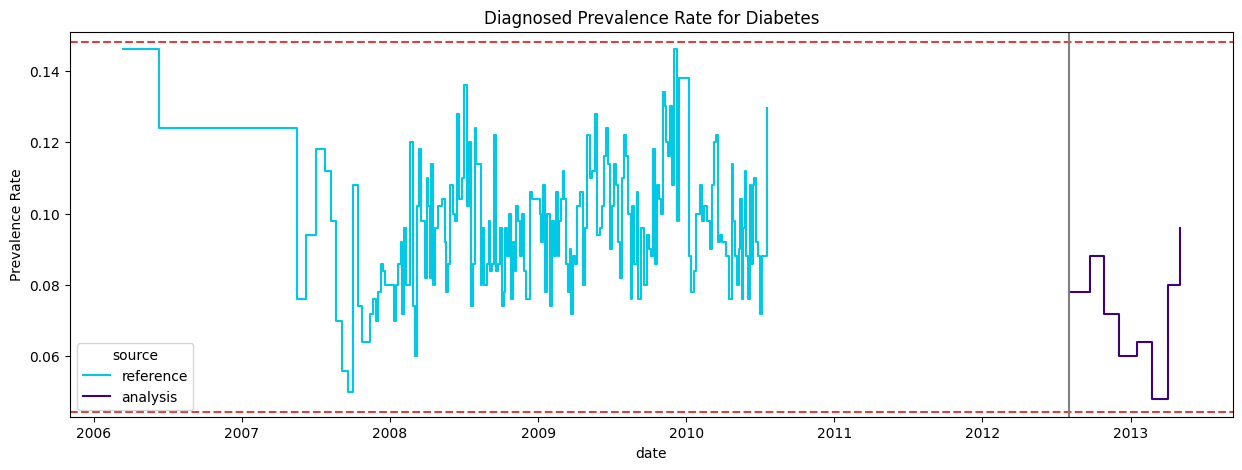

In [11]:
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.lineplot(
            x=df_PrevRate.index, y=df_PrevRate.prevalenceRate,
            data=df_PrevRate, ax=ax, drawstyle='steps-post',
            hue="source", palette = [colors.BLUE_SKY_CRAYOLA, colors.INDIGO_PERSIAN],
            ci=None
            )
plt.axhline(source_mean.loc["reference"].prevalenceRate + 3*source_std.loc["reference"].prevalenceRate, linestyle="--", color=colors.RED_IMPERIAL)
plt.axhline(source_mean.loc["reference"].prevalenceRate - 3*source_std.loc["reference"].prevalenceRate, linestyle="--", color=colors.RED_IMPERIAL)
plt.axvline(analysis_start, linestyle="-", color="grey")

ax.set_ylabel("Prevalence Rate")
ax.set_title("Diagnosed Prevalence Rate for Diabetes")

plt.show()